Para hacer apply a un daskdataframe es necesario pasarle meta que es el tipo de datos que va a tener. https://stackoverflow.com/a/44437675

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import re
# import locale
# locale.setlocale(locale.LC_TIME, "es_ES") 

In [273]:
plt.style.use('fivethirtyeight')

In [2]:
oferta = pd.read_pickle('./datos/output/pickles/oferta_diaria_media.pickle')

In [274]:
def graficar(dataset: pd.DataFrame,num_linea:int,franja:str,valores:str='MediaCochesMes',guardar:bool=False):
    '''
    Funcion que genera un gráfico de lineas para los meses de 2019, 2020 y 2021 en la franja hora que se espcifica.
    Parameters
    ----------
    dataset   : DataFrame. Datos generales sobre las líneas o línea.
    num:linea : int. Número de la línea que se quiere consultar.
    franja    : str. Intervalo horario que se quiere consultar.
    valores   : str. Nombre de la medida que se quiere consultar.
    guardar   : bool. Opción para exportar y guardar la imagen. `False` por defecto   
    '''
    fig, axes = plt.subplots(figsize=(12, 3),dpi=100)
    axes.spines.right.set_visible(False)
    axes.spines.top.set_visible(False)

    # num_linea = 21
    # franja = 'H10'

    # Filtro por linea y franja
    listado_franjas = dataset.loc[dataset['CLinea']==num_linea,'IDFranja'].unique()

    dataset = dataset[(dataset['CLinea']==num_linea)&(dataset['IDFranja']==franja)]
    dataset = dataset.dropna(subset=[valores]).drop_duplicates(subset=['fechaCorta']).reset_index(drop=True)
    
    if len(dataset)==0:
        raise Exception(f"Las franjas horarias de la linea {num_linea} son: {listado_franjas}") 
        
    lineaPublico = str(dataset.loc[0,"Elinea"])
    cartel_linea = str(dataset.loc[0,"Denominacion"])

    # Visualizo los datos (media) y fechas
    for fecha in dataset['FServicio'].dt.year.unique():
        axes.plot(dataset.loc[dataset['FServicio'].dt.year == fecha,'fechaCorta'],dataset.loc[dataset['FServicio'].dt.year == fecha, valores],'-o',label='Franja: '+ franja +'\nAño: '+str(fecha))


    # Configuraciones visuales
    axes.set_xticks(dataset['fechaCorta'])
    axes.set_xticklabels(dataset['fechaCorta'], rotation = 45, ha="right")
    
    # axes.set_yticks(range(0,int(dataset[valores].max()+3)))
    axes.set_ylim([0,dataset[valores].max()+3])

    xTicks = axes.get_xticklabels()
    indices_enero = [i for i, fecha in enumerate(dataset['FServicio']) if fecha.month==1]
            

    for indiceEnero in indices_enero:
        xTicks[indiceEnero].set_weight('bold')
    
    # Título y nombre ejes
    axes.set_xlabel('Fecha')
    axes.set_ylabel('# Autobuses')
    axes.set_title(label=f'Evolución núm. autobuses ({valores})\nLÍNEA {lineaPublico}: {cartel_linea}',pad=20)

    axes.grid(linestyle='--', linewidth=1, axis='both')

    leg = axes.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0)

    # FALTA POR HACER ESTO-> Poner una caja debajo de las leyedenas que muestren datos como máx y min
    # p = leg.get_window_extent()
    # print(p)
    # axes.annotate('Annotation Text', (p.p0[0], p.p1[1]+10), (p.p0[0], p.p1[1]), 
    #             xycoords='figure pixels', zorder=9)


    # plt.legend(loc="lower right") # Esto puede deshabilitar quitando la línea
    if guardar:
        plt.savefig(fname=f'images/LÍNEA_{num_linea}_{franja}_{cartel_linea}.jpg',format='jpg', bbox_inches='tight', dpi=200)


    fig.set_facecolor('white')

    plt.show()

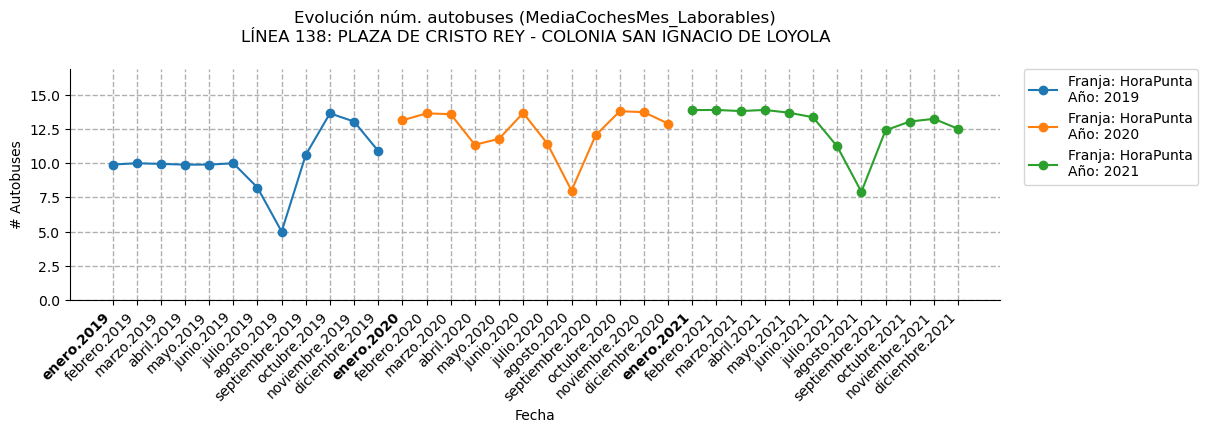

In [275]:
# [MediaCochesMes, MediaCochesLaborables]

graficar(dataset=oferta,num_linea=138,franja='HoraPunta',valores='MediaCochesMes_Laborables')

In [80]:
oferta[(oferta['IDFranja']=='H08') & (oferta['fechaCorta']==pd.to_datetime('24/05/2021',dayfirst=True))]['Coches'].sum()

42290.0

In [190]:
oferta['year'] = oferta['FServicio'].dt.year
oferta['month'] = oferta['FServicio'].dt.month

oferta['coches_dia'] = oferta.groupby(by=['FServicio','IDFranja'])['Coches'].transform('sum')
oferta['coches_mes_dia'] = oferta.groupby(by=['year','month','IDFranja'])['coches_dia'].transform('mean')

In [445]:
HORAS_DIURNAS = ['H07','H08','H09','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23','HoraPunta']

In [184]:
oferta.loc[(oferta['fechaCorta']=="mayo.2019") & (oferta['IDFranja'].isin(HORAS_DIURNAS) & (oferta['dayType']=='LA')),['IDFranja','FServicio','coches_dia','coches_mes_dia','dayType']].sort_values(by=['coches_mes_dia'],ascending=[False]).drop_duplicates()

,IDFranja,FServicio,coches_dia,coches_mes_dia,dayType
22248,HoraPunta,2019-05-30,1731.500000,1728.507613,LA
14334,HoraPunta,2019-05-31,1739.500000,1728.507613,LA
5829,HoraPunta,2019-05-23,1743.833333,1728.507613,LA
14330,HoraPunta,2019-05-27,1726.166667,1728.507613,LA
14331,HoraPunta,2019-05-28,1745.166667,1728.507613,LA
...,...,...,...,...,...
458516,H23,2019-05-09,772.000000,712.083897,LA
591588,H23,2019-05-06,768.000000,712.083897,LA
539230,H23,2019-05-17,774.000000,712.083897,LA
587154,H23,2019-05-07,770.000000,712.083897,LA


In [471]:
oferta_ymf = oferta.loc[oferta['IDFranja'].isin(HORAS_DIURNAS),['IDFranja','month','year','coches_mes_dia']].set_index(['year','month','IDFranja']).drop_duplicates().copy()
oferta_ymf

coches_mes_dia
year month IDFranja                 
2019 1     H07           1222.848711
           H08           1401.016782
           H09           1441.963541
           H10           1344.225422
           H11           1233.341709
...                              ...
2021 12    H20           1238.570615
           H21           1057.589877
           H22            881.585616
           H23            684.405515
           HoraPunta     1640.098792

[648 rows x 1 columns]

In [472]:
oferta_ymf = oferta_ymf.reset_index().copy()

In [494]:
oferta_ymf.sort_values(by=['coches_mes_dia'],ascending=False)

,year,month,IDFranja,coches_mes_dia
503,2021,4,HoraPunta,1785.699876
467,2021,2,HoraPunta,1777.941391
521,2021,5,HoraPunta,1771.206322
251,2020,2,HoraPunta,1769.350282
413,2020,11,HoraPunta,1768.578947
...,...,...,...,...
142,2019,8,H23,593.883106
574,2021,8,H23,592.749508
358,2020,8,H23,591.521791
286,2020,4,H23,576.088799


In [390]:
from matplotlib.ticker import (AutoMinorLocator)

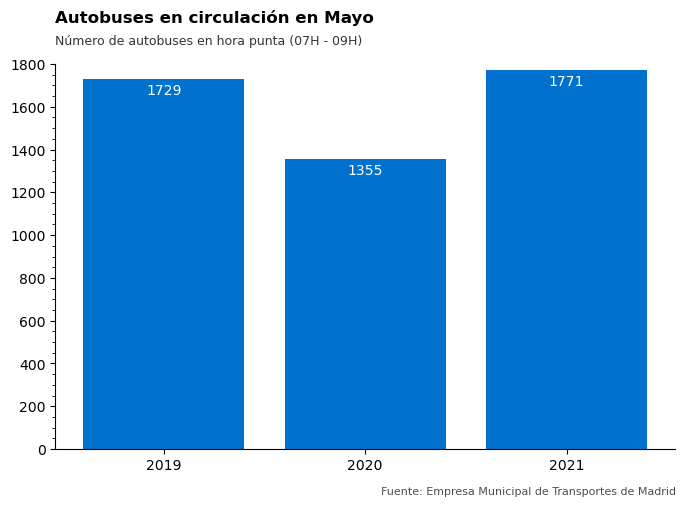

In [512]:
from re import A


fig, ax = plt.subplots(figsize=(8, 5),dpi=100)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

COLORES_CORPORATIVOS = ['#0072CE','#E31C79','#00968F','#D9C756','#FE5000','#B1B3B3']
DATA = oferta.loc[(oferta['IDFranja']=='HoraPunta')&(oferta['month']==5),['IDFranja','month','year','coches_mes_dia']].drop_duplicates().set_index(['year'])['coches_mes_dia']

bars = ax.bar(range(2019,2022),DATA,label=range(2019,2022),color=COLORES_CORPORATIVOS[0])

ax.set_xticks(range(2019,2022))
ax.set_yticks(range(0,1800,200),minor=True)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim(0,1800)

ax.set_title('Autobuses en circulación en Mayo',loc='left',size=12,pad=30,weight='bold')
# Add in title and subtitle
ax.text(x=.125, y=.92, 
        s="Número de autobuses en hora punta (07H - 09H)", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=9, 
        alpha=.8)
# Set source text
ax.text(x=.532, y=0.02, 
        s="""Fuente: Empresa Municipal de Transportes de Madrid""", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=8, 
        alpha=.7)
ax.bar_label(bars,padding=-13,color='white',fmt='%.0f')
ax.plot()
fig.savefig(fname='images/autobueses_circulación_mayo.png')

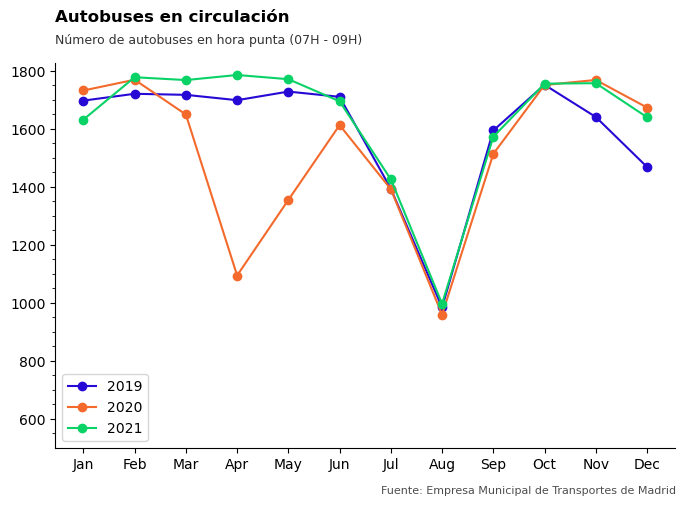

In [403]:
COLORES = ['#2709d6','#f36a2c','#09d267']

fig, ax = plt.subplots(figsize=(8, 5),dpi=100)
for i_color,year in enumerate(range(2019,2022)):
    ax.plot(oferta.loc[(oferta['IDFranja']=='HoraPunta')&(oferta['year']==year),['IDFranja','month','year','coches_mes_dia']].drop_duplicates().set_index(['month'])[['coches_mes_dia']],'-o',label=str(year),color=COLORES[i_color])

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_ylim(500)
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.set_xticks(range(1,13))
ax.set_xticklabels(pd.date_range('2022-01-01','2022-12-31',freq='MS').strftime("%b").tolist())
ax.set_title('Autobuses en circulación',loc='left',size=12,pad=30,weight='bold')
# Add in title and subtitle
ax.text(x=.125, y=.92, 
        s="Número de autobuses en hora punta (07H - 09H)", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=9, 
        alpha=.8)
# Set source text
ax.text(x=.532, y=0.02, 
        s="""Fuente: Empresa Municipal de Transportes de Madrid""", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=8, 
        alpha=.7)

ax.legend()
ax.plot()
fig.savefig(fname='images/autobueses_circulación.png')

# Líneas con mayor afluencia de pasajeros
Según este tweet de [@EMTmadrid](https://twitter.com/emtmadrid/status/956855958369701889?lang=es) las líneas con mayor demanda en 2017 son: L34, L27, L70, C1, C2, L31, L28, L35 y L17.

La demanda de estas líneas supone un 26.5% del total, equivalente 113 millones de pasajeros en dicho año.

In [12]:
numero_viajeros = pd.read_csv('datos/output/numero_viajeros.csv')
aclaraciones = pd.read_csv('datos/output/aclaraciones_ocupacion_lineas.csv')

In [13]:
ranking = numero_viajeros.iloc[:,:3].copy()

In [14]:
for year in range(2014,int(numero_viajeros.columns[-1])):
    rank = numero_viajeros.loc[:,['Código',str(year)]].sort_values(by=[str(year)], ascending=False)
    rank[str(year)] = rank.reset_index().index+1
    # numero_viajeros[str(year)].sort_values(ascending=False).reset_index().rename(columns={'index':'Código'})
    ranking = ranking.merge(rank)

In [15]:
# Debería cambiar este tipo de tabla por una que fueran las filas los años y las columnas el top10. De esa forma conseguiría mostrar siempre las 10 líneas para cada año y no como se muestra ahora que son las 10 líneas más usadas en el último año (2021).

ranking.sort_values(by='2021').iloc[0:10,:]

,Código,Etiqueta,Denominación,2014,2015,2016,2017,2018,2019,2020,2021
32,34,34,PLAZA DE CIBELES - LAS AGUILAS,2,2,2,1,1,1,1,1
68,70,70,PLAZA DE CASTILLA - ALSACIA,5,5,5,3,3,3,2,2
25,27,27,GLORIETA DE EMBAJADORES - PLAZA DE CASTILLA,1,1,1,2,2,2,3,3
67,69,C2,CIRCULAR 2 -,4,4,4,5,5,5,6,4
66,68,C1,CIRCULAR 1 -,3,3,3,4,4,4,5,5
29,31,31,PLAZA MAYOR - ALUCHE,6,6,6,6,7,8,7,6
26,28,28,PUERTA DE ALCALA - BARRIO DE CANILLEJAS,8,8,9,8,8,7,8,7
19,21,21,PASEO DEL PINTOR ROSALES - BARRIO EL SALVADOR,7,7,7,7,6,6,4,8
33,35,35,PLAZA MAYOR - CARABANCHEL ALTO,9,9,8,9,9,9,9,9
128,138,138,PLAZA DE CRISTO REY - COLONIA SAN IGNACIO DE L...,61,58,60,54,38,29,11,10


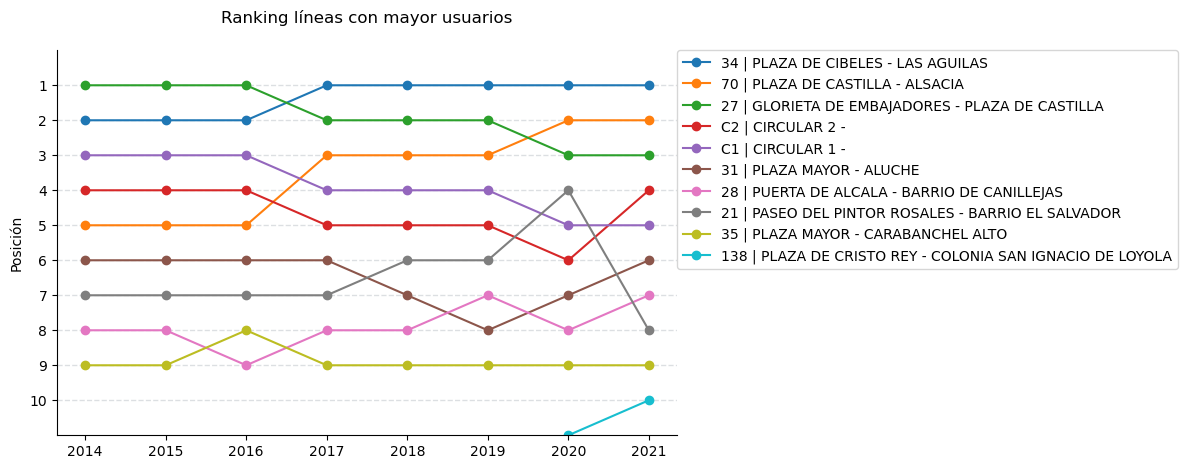

In [167]:
data = ranking.sort_values(by='2021').iloc[0:10,:].reset_index(drop=True)

fig, axes = plt.subplots(figsize=(8, 5),dpi=100)
axes.spines.right.set_visible(False)
axes.spines.top.set_visible(False)

# Visualizo los datos (avg_coches) y fechas

years = ranking.columns[3:]
axes.plot(years,data.iloc[:,3:].T.values,'-o',label=data['Etiqueta'] + ' | ' +data['Denominación'])

# # Título y nombre ejes
# axes.set_xlabel('Años')
axes.set_ylabel('Posición')
axes.set_title(label=f'Ranking líneas con mayor usuarios',pad=20)
   
axes.set_xticks(range(0,len(years)))
axes.set_xticklabels(years)
axes.set_ylim(0,11)
axes.set_yticks(range(1,11))
axes.invert_yaxis()

axes.grid(color="#172a3d", linestyle='--', linewidth=1, axis='y', alpha=0.15)
axes.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0,)
fig.set_facecolor('white')
plt.show()

## Aclaraciones

|    |   Año | Informacion                                                                                 |
|---:|------:|:--------------------------------------------------------------------------------------------|
|  0 |  2019 | (1)  El Servicio Especial 721 solo funciona los días de evento en el Estadio Metropolitano. |
|  1 |  2019 | (2)  El 1 de abril de 2019 el Servicio Especial 722 se transforma en la línea 166.          |
|  2 |  2020 | (1)  El Servicio Especial 721 solo funciona los días de evento en el Estadio Metropolitano. |
|  3 |  2020 | (2)  El 18 de febrero se crea la línea 361.                                                 |
|  4 |  2020 | (3)  El 3 de marzo de 2020 la línea 602 se prolonga y se transforma en la línea 362.        |
|  5 |  2020 | (4)  El 16 de marzo de 2020 el Servicio Especial 723 se transforma en la línea 159.         |
|  6 |  2020 | (5)  El Servicio Especial 710 funciona del 23 de marzo al 24 de mayo de 2020.               |
|  7 |  2020 | (6)  El 15 de septiembre se crea la línea 363.                                              |
|  8 |  2020 | (7)  El 7 de octubre se crea el Servicio Especial 712.                                      |
|  9 |  2021 | (1)  El Servicio Especial 721 solo funciona los días de evento en el Estadio Metropolitano. |
| 10 |  2021 | (2)  El 16 de febrero se crea la línea 167.                                                 |
| 11 |  2021 | (3)  El 2 de marzo se crea la línea 163.                                                    |
| 12 |  2021 | (4)  El 17 de marzo se crea la línea 405.                                                   |
| 13 |  2021 | (5)  El 1 de septiembre se crea el Servicio Especial 708.                                   |


## Servicios Especiales (SE) --> Habituales

Además, hay otras aclaraciones que no se contemplan como el cambio de `Servicio Especial` a  `Regular` de la línea con tramo `MAR DE CRISTAL - VALDEBEBAS`. Pero eso no siempre es así, en ocasiones 2 líneas pueden tener el mismo nombre pero realizar trayectos diferentes.

Este puede ser el caso de las líneas `22` y `79` que reciben en ambos caso la denominación de _`PLAZA DE LEGAZPI - VILLAVERDE ALTO`_

In [17]:
numero_viajeros['Denominación'].value_counts().to_frame()[numero_viajeros['Denominación'].value_counts().to_frame().rename(columns={'Denominación':'count'})['count']==2]

,Denominación
ALSACIA - HOSPITAL RAMON Y CAJAL,2
PLAZA DE CIBELES - PALOMERAS,2
PUERTA DE TOLEDO - ARGÜELLES,2
MAR DE CRISTAL - VALDEBEBAS,2
PLAZA DE LEGAZPI - VILLAVERDE ALTO,2
BARAJAS - HOSPITAL RAMON Y CAJAL,2
PLAZA MAYOR - VILLAVERDE CRUCE,2
MONCLOA - ARAVACA,2
PLAZA DE CASTILLA - BARRIO DE PEÑAGRANDE,2


In [19]:
numero_viajeros[numero_viajeros['Denominación']=="PLAZA DE LEGAZPI - VILLAVERDE ALTO"]

,Código,Etiqueta,Denominación,2014,2015,2016,2017,2018,2019,2020,2021,2022
20,22,22,PLAZA DE LEGAZPI - VILLAVERDE ALTO,1870951,1780063,1848495,1853754,2090211,2250369,1202753,1492295,746364
77,79,79,PLAZA DE LEGAZPI - VILLAVERDE ALTO,1034255,1085020,1148193,1162509,1205486,1226949,758516,958153,463169


In [20]:
numero_viajeros[numero_viajeros['Denominación']=="MAR DE CRISTAL - VALDEBEBAS"]

,Código,Etiqueta,Denominación,2014,2015,2016,2017,2018,2019,2020,2021,2022
155,171,171,MAR DE CRISTAL - VALDEBEBAS,0,0,484127,471277,595458,704949,478455,663449,324996
268,799,SE,MAR DE CRISTAL - VALDEBEBAS,92731,337471,0,0,0,0,0,0,0


In [95]:
columnas_calculo = dict()

for year in range(int(numero_viajeros.columns[3:].min()),int(numero_viajeros.columns[3:].max())+1,1):
    columnas_calculo[str(year)] = 'sum'

numero_viajeros.groupby(by=['Denominación']).agg({**columnas_calculo,**{'Denominación':'count'}}).rename(columns={'Denominación':'count'}).sort_values(by='count',ascending=False)


In [21]:
lineas_espciales = numero_viajeros[numero_viajeros['Código']>=700][['Código','Etiqueta','Denominación']].reset_index(drop=True)
lineas_habituales = numero_viajeros[numero_viajeros['Código']<700][['Código','Etiqueta','Denominación']].reset_index(drop=True)

In [38]:
print(f'Lineas habituales: {len(lineas_habituales["Denominación"])} / Líneas SE: {len(lineas_espciales["Denominación"])} / Diferencia: {len(set(lineas_habituales["Denominación"])-set(lineas_espciales["Denominación"]))}')

Lineas habituales: 217 / Líneas SE: 52 / Diferencia: 208


In [24]:
lineas_habituales.join(other=lineas_espciales.set_index('Denominación'),on=['Denominación'],rsuffix='_SE',how='inner')

,Código,Etiqueta,Denominación,Código_SE,Etiqueta_SE
151,165,165,ALSACIA - HOSPITAL RAMON Y CAJAL,720,SE
152,166,166,BARAJAS - HOSPITAL RAMON Y CAJAL,722,SE
155,171,171,MAR DE CRISTAL - VALDEBEBAS,799,SE


In [149]:
numero_viajeros['media'] = numero_viajeros.iloc[:,3:].apply(lambda x: x.mean(),axis=1)
numero_viajeros['media_sin_2022'] = numero_viajeros.iloc[:,3:11].apply(lambda x: x.mean(),axis=1)

numero_viajeros.sort_values(by='2021',ascending=False)

,Código,Etiqueta,Denominación,2014,2015,2016,2017,2018,2019,2020,2021,2022,media,media_sin_2022
32,34,34,PLAZA DE CIBELES - LAS AGUILAS,7840818,7984636,8363237,8575908,8496485,8986303,5167825,6650128,3432417,7.325556e+06,7758167.500
68,70,70,PLAZA DE CASTILLA - ALSACIA,7122258,7129357,7252981,7508617,7286532,7677360,4416674,5228237,2714421,6.303886e+06,6702752.000
25,27,27,GLORIETA DE EMBAJADORES - PLAZA DE CASTILLA,8902761,8767669,8916906,8269113,7750416,8230803,3970651,4795961,2428158,6.948255e+06,7450535.000
67,69,C2,CIRCULAR 2 -,7278401,7239262,7442740,7003394,6686799,6926192,3581783,4483508,2357121,5.932913e+06,6330259.875
66,68,C1,CIRCULAR 1 -,7478016,7333224,7483436,7161191,6832968,6989959,3605080,4434154,2359257,6.009170e+06,6414753.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,732,SE,PUERTA DE ARGANDA - SAINZ DE BARANDA,0,8268,0,0,331646,0,0,0,0,3.823997e+04,42489.250
107,117,117,ALUCHE - COLONIA SAN IGNACIO DE LOYOLA,1008768,1001468,979882,906343,1111297,832268,0,0,0,6.569968e+05,730003.250
243,737,SE,LEGAZPI - LAGUNA,0,0,0,0,0,0,0,0,28,2.800234e+00,0.000
244,739,SE,POZUELO - HOSPITAL ENFERMERA ISABEL ZENDAL,0,0,0,0,0,0,0,0,8076,8.076674e+02,0.000


In [ ]:
numero_viajeros[numero_viajeros['Etiqueta']=='SE']

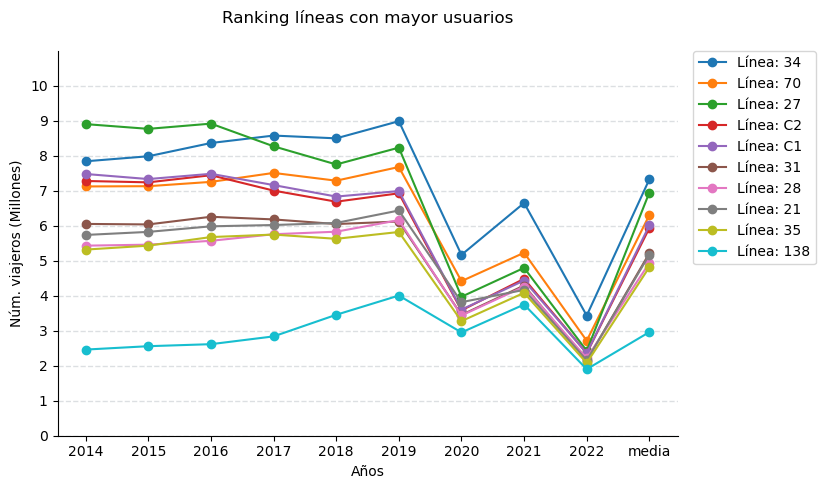

In [163]:
fig, axes = plt.subplots(figsize=(8, 5),dpi=100)

# Ocultar boordes del gráfico
axes.spines.right.set_visible(False)
axes.spines.top.set_visible(False)

# Visualización de los datos
years = numero_viajeros.columns[3:-1].values
axes.plot(years,numero_viajeros.sort_values(by='2021',ascending=False).iloc[0:10,3:-1].apply(lambda x: x/(10**6)).T.values,'-o',label='Línea: '+data['Etiqueta'])

# Rejilla
axes.grid(color="#172a3d", linestyle='--', linewidth=1, axis='y', alpha=0.15)

# Título y nombre de los ejes
axes.set_xlabel('Años')
axes.set_ylabel('Núm. viajeros (Millones)')
axes.set_title(label=f'Ranking líneas con mayor usuarios',pad=20)



# axes.set_xticks(range(0,len(years)))
# axes.set_xticklabels(years)

# Pasamos a decimal los datos (/10^6) para poder mostrarlos en formato decimal de millones 
y_max = round(max(numero_viajeros.sort_values(by='2021',ascending=False).iloc[:,3:-1].max().apply(lambda x: x/(10**6)).to_list()))
axes.set_ylim(0,y_max+2)
axes.set_yticks(range(0,y_max+2))

# Leyenda y fondo en blanco del gráfico
axes.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0)
fig.set_facecolor('white')
plt.show()
plt.close()